In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from ast import literal_eval
import numpy as np
from pytrends.request import TrendReq
import math

In [2]:
tab_years=np.arange(1999,2022+1)
tab_years

a_cols = ['wikipedia_m_ID', 'freebase_m_ID', 'm_release_date','character_name', 'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age', 'freebase_character_map', 'freebase_character_id', 'freebase_actor_id']
df_actors=pd.read_csv('character.metadata.tsv', sep='\t', names=a_cols, parse_dates=['m_release_date'])
df_actors['m_release_date']=pd.to_datetime(df_actors['m_release_date'], errors = 'coerce')##min value of date '1010-12-02' qui plus petit que la plus petite date de to_datetime

#Change problematic dates
df_actors['actor_dob'] = df_actors['actor_dob'].apply(lambda x: str(x) if len(str(x)) <=10 else str(x)[:10])
df_actors['actor_dob'] = pd.to_datetime(df_actors['actor_dob'], errors = 'coerce')
df_actors.dropna(subset='actor_name', inplace=True)
df_actors.drop_duplicates(keep='first', inplace=True)
df_actors.drop_duplicates(subset=["wikipedia_m_ID", "character_name", "actor_name", "m_release_date"], keep=False, inplace=True)
#df_actors.head()

m_cols = ["wikipedia_m_ID", "freebase_m_ID", "m_name", "m_release_date", "m_BO_revenue", "m_runtime", "m_languages", "m_countries", "m_genres"]
df_movies=pd.read_csv('movie.metadata.tsv', sep='\t', names=m_cols, converters={'m_languages': literal_eval, 'm_countries': literal_eval, 'm_genres': literal_eval})
df_movies['m_release_date']=pd.to_datetime(df_movies['m_release_date'], errors = 'coerce')##min value of date '1010-12-02' qui plus petit que la plus petite date de to_datetime
df_movies=df_movies.where(df_movies.astype(bool),np.nan).drop_duplicates(subset=['m_name', 'm_runtime'])
#df_movies.head()


In [3]:
df_actors.head()

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [4]:
df_movies.head()

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D..."
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'}


In [5]:
def split_feature(row, feature, flag):
    
    if isinstance(row[feature], float):
        return np.nan
    elif flag:
        return list(row[feature].values())
    else:
        return row[feature].keys()
features=['m_languages', 'm_countries', 'm_genres']
_freebase_ID='_freebase_ID'
for i, feature in enumerate(features):
    df_movies[feature+_freebase_ID]=df_movies.apply(lambda row: split_feature(row, feature, 0), axis=1)
    df_movies[feature]=df_movies.apply(lambda row: split_feature(row, feature, 1), axis=1)

In [6]:
df_countries_m = df_movies.explode('m_countries').dropna(subset='m_countries')
df_movies_USA = df_countries_m[df_countries_m['m_countries']=='United States of America']
df_m_a = df_movies_USA.merge(df_actors, left_on=['wikipedia_m_ID', 'freebase_m_ID', 'm_release_date'], right_on=['wikipedia_m_ID', 'freebase_m_ID', 'm_release_date'])

In [7]:
df_m_a_release=df_m_a[['m_name', 'm_release_date', 'character_name', 'actor_name']]
df_m_a_release.head()

,m_name,m_release_date,character_name,actor_name
0,Ghosts of Mars,2001-08-24,Akooshay,Wanda De Jesus
1,Ghosts of Mars,2001-08-24,Lieutenant Melanie Ballard,Natasha Henstridge
2,Ghosts of Mars,2001-08-24,Desolation Williams,Ice Cube
3,Ghosts of Mars,2001-08-24,Sgt Jericho Butler,Jason Statham
4,Ghosts of Mars,2001-08-24,Bashira Kincaid,Clea DuVall


### The numbers data: Domestic Per Year Acting Box Office Star Records

### What is this extra dataset, why did we need one and what does it contain ?
This website extracts, analyses and offers interesting data about movies. They call themseleves "the premier provider of movie industry data and research services." As they permit hand-copying data from their website, [the domestic per year acting box office star records from year 1980 to 2022](https://www.the-numbers.com/box-office-star-records/domestic/yearly-acting/) have been extracted and zipped. This freshly scraped data contains the actor's name, the "popularity index" and the average billing rate.

The popularity index represent points assigned to each of the acotr·ress appearing in the top 100 (based on US box office) movies in the current year and two preceding years. For appearing in the number one movie in a year a acotr·ress gets 100 points, the number two movie 99 points and so on.

The box office is a debatble metric as it does not take into acount the wage of the cast, the cost of filiming nor the revenues of the streaming platforms (one time download or subscription to the plateform). Thankfully the latter has little or no influence for BO computed before 2000.

Nevertheless, we will still use this metric as it's so common standard in the movie industry.

#### But why did we need this dataset ?

In order to help answer our question, a popularity index for the actors has to be used. This will allow us to analyse the co-acting. For example if a not popular actor has a peak in it's poularity index, we retrieve all the films in which they've played during that time. They may be or not a popular acotr·ress that was part of the cast and thanks to the latter the career of the first has boomed. This is one of many possible ways to analysis the co-acting

In [93]:
#CONSTANTS
YEAR_OFFSET=2 # if 3: last triplet 2019, 2020, 2021;; if 2: last triplet 2020, 2021, 2022
START_INDEX=20 # 20 correspond to the triplet 2000, 2001, 2002
START_YEAR=1980+START_INDEX

In [94]:
#red the tsv files having the actor's popularity
tab_years=np.arange(1980,2022+1)
actors_rating=[]
for i, year in enumerate (tab_years):
    actors_rating.append(pd.read_csv('actors_xxxx_the_numbers/actors_{}_the_numbers.tsv'.format(year),
                              sep='\t',
                              escapechar=',',
                              names=['actor_name','popularity', 'movies', 'avg_billing']))


In [95]:
#check for duplicated actor name for each year
total_duplicated=0
for i in range (len(tab_years)):
    total_duplicated+=actors_rating[i].duplicated(subset='actor_name').sum()
print('There are {} actors that appaer twice in the same year.'.format(total_duplicated))


There are 0 actors that appaer twice in the same year.


In [96]:
#formating the dataset in usefuel way
df_ratings_all_years=actors_rating[0].set_index('actor_name')[['popularity']]
df_ratings_all_years.set_axis([*df_ratings_all_years.columns[:-1], '{}'.format(1980)], axis=1, inplace=True)
for i in range (len(tab_years)-1):
    df_ratings_all_years=pd.concat([df_ratings_all_years, actors_rating[i+1].set_index('actor_name')[['popularity']]],  axis=1)
    df_ratings_all_years.set_axis([*df_ratings_all_years.columns[:-1], '{}'.format(i+1+1980)], axis=1, inplace=True)
df_ratings_all_yearsT=df_ratings_all_years.T

ACTORS=list(df_ratings_all_yearsT)#all the actors present in the numbers dataset

In [97]:
df_ratings_all_years['mean_score'] = df_ratings_all_years.mean(axis=1)
print("Actors this the highest mean popularity score computed on the 42 years of the dataset.")
df_ratings_all_years.sort_values(by='mean_score', ascending=False).head()

Actors this the highest mean popularity score computed on the 42 years of the dataset.


,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,mean_score
actor_name,,,,,,,,,,,,,,,,,,,,,
Jennifer Lawrence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,561.0,518.0,489.0,298.0,195.0,97.0,97.0,57.0,NaN,283.636364
Chris Hemsworth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,330.0,198.0,216.0,309.0,342.0,394.0,301.0,165.0,95.0,265.666667
Chris Pratt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98.0,197.0,337.0,335.0,432.0,392.0,296.0,100.0,98.0,253.888889
Kevin Hart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,248.0,304.0,437.0,368.0,307.0,324.0,227.0,165.0,NaN,252.900000
John Candy,NaN,NaN,NaN,NaN,NaN,205.0,253.0,405.0,276.0,331.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,241.666667


Text(0, 0.5, 'Score')

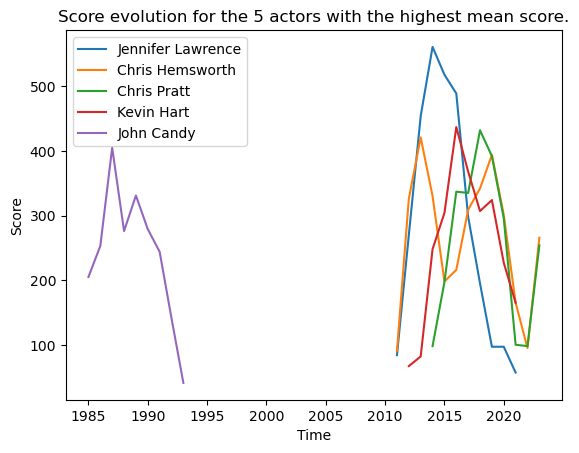

In [98]:
df_ratings_all_years.sort_values(by='mean_score', ascending=False).head().rename_axis(None).T.plot()
plt.title("Score evolution for the 5 actors with the highest mean score.")
plt.xlabel('Time')
plt.ylabel('Score')

In [99]:
df_ratings_all_years['is_na']=df_ratings_all_years.apply(lambda row: row.isna().sum().sum(), axis=1)
print("Actors that have the least \"empty years\" throughout the 42 years of the dataset.")
df_ratings_all_years.sort_values(by='is_na', ascending=True).head(3)

Actors that have the least "empty years" throughout the 42 years of the dataset.


,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2015,2016,2017,2018,2019,2020,2021,2022,mean_score,is_na
actor_name,,,,,,,,,,,,,,,,,,,,,
Harrison Ford,158.0,258.0,279.0,279.0,277.0,290.0,234.0,136.0,179.0,234.0,...,130.0,22.0,67.0,67.0,67.0,95.0,95.0,95.0,158.837209,0
Robert De Niro,169.0,115.0,115.0,39.0,28.0,28.0,80.0,92.0,165.0,130.0,...,185.0,129.0,129.0,20.0,NaN,86.0,86.0,141.0,147.238095,1
Meryl Streep,162.0,229.0,141.0,223.0,184.0,206.0,188.0,160.0,64.0,35.0,...,141.0,125.0,80.0,227.0,220.0,158.0,NaN,NaN,127.800000,3


Text(0, 0.5, 'Score')

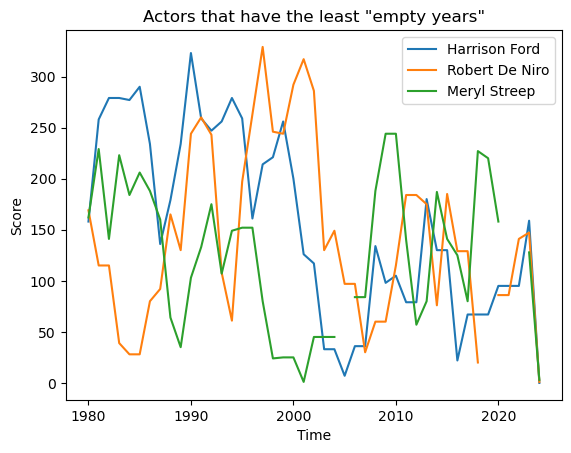

In [100]:
df_ratings_all_years.sort_values(by='is_na', ascending=True).head(3).rename_axis(None).T.plot()
plt.title("Actors that have the least \"empty years\"")
plt.xlabel('Time')
plt.ylabel('Score')

In [101]:
def find_yearly_actors(row):
    """
    finds all the actors that have a popularity score in a given year.
    :param row: each row of the dataframe sent by .apply()
    :return: dictionnary with each actor and the score of a given year
    """
    year_dict={}
    for i, actor in enumerate (ACTORS):
        if row[actor] > 0:
            year_dict.update({'{}'.format(actor):row[actor]})
    return year_dict

df_ratings_all_yearsT['have_score']=df_ratings_all_yearsT.apply(lambda row: find_yearly_actors(row), axis=1)
list_have_score=df_ratings_all_yearsT['have_score'].tolist()
df_ratings_all_yearsT.head()

actor_name,Jane Fonda,Clint Eastwood,John Belushi,Burt Reynolds,Goldie Hawn,Chevy Chase,Alan Alda,Laurence Olivier,Chuck Norris,John Travolta,...,Jenna Ortega,Billy Eichner,Luke Macfarlane,Maria Bakalova,Myha’la Herrold,Chase Sui Wonders,Rachel Sennott,Pete Davidson,Lesley Manville,have_score
1980,440.0,360.0,269.0,262.0,258.0,248.0,227.0,206.0,201.0,188.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 440.0, 'Clint Eastwood': 360.0,..."
1981,364.0,263.0,295.0,84.0,170.0,289.0,62.0,67.0,131.0,132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 364.0, 'Clint Eastwood': 263.0,..."
1982,198.0,260.0,217.0,NaN,251.0,289.0,NaN,NaN,105.0,132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 198.0, 'Clint Eastwood': 260.0,..."
1983,99.0,180.0,125.0,NaN,81.0,261.0,NaN,NaN,87.0,208.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 99.0, 'Clint Eastwood': 180.0, ..."
1984,NaN,347.0,NaN,NaN,147.0,132.0,NaN,NaN,143.0,164.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Clint Eastwood': 347.0, 'Goldie Hawn': 147.0..."


In [102]:
list_have_score_triplet=[]
temp_dict={}

for i in range (len(list_have_score)-YEAR_OFFSET):
    """
    find actors that have a score in three consecutive years n, n+1, n+2. 
    """
    intersection=list(set(list_have_score[i].keys()) & set(list_have_score[i+1].keys()) & set(list_have_score[i+2].keys()))
    have_score_3years={actor : [list_have_score[i][intersection[j]], list_have_score[i+1][intersection[j]], list_have_score[i+2][intersection[j]]] for j, actor in enumerate(intersection)}
    list_have_score_triplet.append(have_score_3years)
    
for i in range (YEAR_OFFSET):
    list_have_score_triplet.append(temp_dict)
    
df_ratings_all_yearsT['have_score_triplet']=list_have_score_triplet

In [103]:
def find_peak(x, threshold=80):
    """
    find a peak of popularity in the carrier of an actor. A peak is defined if from one year to another the popularity has increased by a given thershold.
    :param x: each line of the 'have_score_triplet' column sent by .apply()
    :return: dictionnary with the actors that have a peak in popularity for a given year triplet
    """
    temp_dict={}
    for key, value in x.items():
        if (value[0]+threshold<value[1] or value[1]+threshold<value[2]):
            value.append(1)
        else:
            value.append(0)
        temp_dict.update({key:value})
    return temp_dict

df_ratings_all_yearsT['have_score_triplet']=df_ratings_all_yearsT['have_score_triplet'].apply(lambda x: find_peak(x))
df_ratings_all_yearsT.head()

actor_name,Jane Fonda,Clint Eastwood,John Belushi,Burt Reynolds,Goldie Hawn,Chevy Chase,Alan Alda,Laurence Olivier,Chuck Norris,John Travolta,...,Billy Eichner,Luke Macfarlane,Maria Bakalova,Myha’la Herrold,Chase Sui Wonders,Rachel Sennott,Pete Davidson,Lesley Manville,have_score,have_score_triplet
1980,440.0,360.0,269.0,262.0,258.0,248.0,227.0,206.0,201.0,188.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 440.0, 'Clint Eastwood': 360.0,...","{'Roger Moore': [93.0, 186.0, 93.0, 0], 'Edwar..."
1981,364.0,263.0,295.0,84.0,170.0,289.0,62.0,67.0,131.0,132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 364.0, 'Clint Eastwood': 263.0,...","{'Brooke Shields': [83.0, 83.0, 83.0, 0], 'Pel..."
1982,198.0,260.0,217.0,NaN,251.0,289.0,NaN,NaN,105.0,132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 198.0, 'Clint Eastwood': 260.0,...","{'Diane Lane': [64.0, 64.0, 64.0, 0], 'Roger M..."
1983,99.0,180.0,125.0,NaN,81.0,261.0,NaN,NaN,87.0,208.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 99.0, 'Clint Eastwood': 180.0, ...","{'Jeff Bridges': [75.0, 147.0, 72.0, 0], 'Fred..."
1984,NaN,347.0,NaN,NaN,147.0,132.0,NaN,NaN,143.0,164.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Clint Eastwood': 347.0, 'Goldie Hawn': 147.0...","{'Jeff Bridges': [147.0, 72.0, 135.0, 0], 'Tam..."


In [104]:
def is_peak (x):
    """
    retrieve all the actors that have a peak within the three consecutive years.
    :param x:  each line of the 'have_score_triplet' column sent by .apply()
    :return: disctionnary with only the actors that have a peak
    """
    my_dict={}
    for key, value in x.items():
        if value[3]==1:
            my_dict.update({key:value})
    return my_dict


df_ratings_all_yearsT['is_peak']=df_ratings_all_yearsT['have_score_triplet'].apply(lambda x: is_peak(x))
print("Actors that have a peak in popularity within 3 years:")
for i in range (df_ratings_all_yearsT.shape[0]-YEAR_OFFSET):
    print("{} for years {}, {}, {}".format(len(df_ratings_all_yearsT.iloc[i]['is_peak']), 1980+i, 1980+i+1, 1980+i+2))
df_ratings_all_yearsT.head()

Actors that have a peak in popularity within 3 years:
0 for years 1980, 1981, 1982
1 for years 1981, 1982, 1983
4 for years 1982, 1983, 1984
8 for years 1983, 1984, 1985
7 for years 1984, 1985, 1986
6 for years 1985, 1986, 1987
9 for years 1986, 1987, 1988
6 for years 1987, 1988, 1989
3 for years 1988, 1989, 1990
5 for years 1989, 1990, 1991
5 for years 1990, 1991, 1992
5 for years 1991, 1992, 1993
3 for years 1992, 1993, 1994
3 for years 1993, 1994, 1995
7 for years 1994, 1995, 1996
6 for years 1995, 1996, 1997
6 for years 1996, 1997, 1998
2 for years 1997, 1998, 1999
3 for years 1998, 1999, 2000
3 for years 1999, 2000, 2001
5 for years 2000, 2001, 2002
4 for years 2001, 2002, 2003
7 for years 2002, 2003, 2004
3 for years 2003, 2004, 2005
2 for years 2004, 2005, 2006
3 for years 2005, 2006, 2007
2 for years 2006, 2007, 2008
5 for years 2007, 2008, 2009
8 for years 2008, 2009, 2010
10 for years 2009, 2010, 2011
9 for years 2010, 2011, 2012
11 for years 2011, 2012, 2013
6 for years 2012

actor_name,Jane Fonda,Clint Eastwood,John Belushi,Burt Reynolds,Goldie Hawn,Chevy Chase,Alan Alda,Laurence Olivier,Chuck Norris,John Travolta,...,Luke Macfarlane,Maria Bakalova,Myha’la Herrold,Chase Sui Wonders,Rachel Sennott,Pete Davidson,Lesley Manville,have_score,have_score_triplet,is_peak
1980,440.0,360.0,269.0,262.0,258.0,248.0,227.0,206.0,201.0,188.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 440.0, 'Clint Eastwood': 360.0,...","{'Roger Moore': [93.0, 186.0, 93.0, 0], 'Edwar...",{}
1981,364.0,263.0,295.0,84.0,170.0,289.0,62.0,67.0,131.0,132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 364.0, 'Clint Eastwood': 263.0,...","{'Brooke Shields': [83.0, 83.0, 83.0, 0], 'Pel...","{'Dennis Quaid': [114.0, 50.0, 203.0, 1]}"
1982,198.0,260.0,217.0,NaN,251.0,289.0,NaN,NaN,105.0,132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 198.0, 'Clint Eastwood': 260.0,...","{'Diane Lane': [64.0, 64.0, 64.0, 0], 'Roger M...","{'Arnold Schwarzenegger': [84.0, 84.0, 230.0, ..."
1983,99.0,180.0,125.0,NaN,81.0,261.0,NaN,NaN,87.0,208.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Jane Fonda': 99.0, 'Clint Eastwood': 180.0, ...","{'Jeff Bridges': [75.0, 147.0, 72.0, 0], 'Fred...","{'Chevy Chase': [261.0, 132.0, 395.0, 1], 'Cli..."
1984,NaN,347.0,NaN,NaN,147.0,132.0,NaN,NaN,143.0,164.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Clint Eastwood': 347.0, 'Goldie Hawn': 147.0...","{'Jeff Bridges': [147.0, 72.0, 135.0, 0], 'Tam...","{'Chevy Chase': [132.0, 395.0, 340.0, 1], 'Tom..."


In [105]:
#this part is done with only one triplet of year to see how this analysis is implemented.
df_filtered_year=df_m_a_release.loc[(df_m_a_release['m_release_date'].dt.year==START_YEAR)|
                                    (df_m_a_release['m_release_date'].dt.year==START_YEAR+1)|
                                    (df_m_a_release['m_release_date'].dt.year==START_YEAR+2)]

In [106]:
actors_of_triplet=list(df_ratings_all_yearsT.iloc[START_INDEX]['is_peak'].keys()) # years 2008, 2009, 2010

#find the films in which the selected actors have played in.
films_with_actor_triplet=df_filtered_year.loc[df_filtered_year['actor_name'].isin(actors_of_triplet)]
print("There are {} movies in which actors that have a peak in popularity for years {}, {}, {} have played in.".format(len(films_with_actor_triplet['m_name'].unique()), START_YEAR, START_YEAR+1, START_YEAR+2))
films_with_actor_triplet.head()



There are 10 movies in which actors that have a peak in popularity for years 2006, 2007, 2008 have played in.


,m_name,m_release_date,character_name,actor_name
10846,Body of Lies,2008-10-05,Ed Hoffman,Russell Crowe
71213,American Gangster,2007-10-19,Richie Roberts,Russell Crowe
99315,Indiana Jones and the Kingdom of the Crystal S...,2008-05-22,Irina Spalko,Cate Blanchett
100876,The Curious Case of Benjamin Button,2008-12-10,Daisy,Cate Blanchett
117097,A Good Year,2006-09-09,Max Skinner,Russell Crowe


In [107]:
print("Some special cases have been found. This is one example: \nIn Iron man 2 Robert Downey Jr. and Scarlette Johansson both appear twice.")
print("This will need to be taken into acocunt when hadling this data.")
films_with_actor_triplet.loc[films_with_actor_triplet['m_name']=='Iron Man 2']


Some special cases have been found. This is one example: 
In Iron man 2 Robert Downey Jr. and Scarlette Johansson both appear twice.
This will need to be taken into acocunt when hadling this data.


,m_name,m_release_date,character_name,actor_name


In [108]:
"""
dictionnary where the keys are the actors and the values are the film in which the've played during the triplet period
"""
m_actors_played_in_triplet={}#unique_films_in_triplet=[]
for i, actor in enumerate (films_with_actor_triplet['actor_name']):
    film_in_triplet=films_with_actor_triplet.loc[films_with_actor_triplet['actor_name']==actor]['m_name'].tolist()
    m_actors_played_in_triplet.update({actor:film_in_triplet})


{'Russell Crowe': ['Body of Lies',
  'American Gangster',
  'A Good Year',
  '3:10 to Yuma'],
 'Cate Blanchett': ['Indiana Jones and the Kingdom of the Crystal Skull',
  'The Curious Case of Benjamin Button',
  'Babel',
  'Hot Fuzz',
  "I'm Not There",
  'The Good German']}